# A Comprehensive Preprocessing Framework for 8-Channel EMG/EEG Upper Limb Gesture 
Data: From Raw Thalmic Labs Myo Armband and OpenBCI Recordings to Curated CSV Datasets (Mendeley DOI:10.17632/m6t78vngbt.1, https://data.mendeley.com/datasets/m6t78vngbt/1)

*Final Outputs:* Curated EMG-Data.csv and EEG-Data.csv specifically formatted for machine learning applications in gesture recognition research.

----

Set up paths, device configuration, and output directories for processing EMG and EEG data with PyTorch.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Path configuration
DATA_ROOT = "data"
INPUT_DIR = os.path.join(DATA_ROOT, "raw")
OUTPUT_DIR = os.path.join(DATA_ROOT, "processed")
EMG_OUTPUT = os.path.join(OUTPUT_DIR, "EMG-data.csv")
EEG_OUTPUT = os.path.join(OUTPUT_DIR, "EEG-data.csv")
EMG_SOURCE = os.path.join(INPUT_DIR, "emg_subjects_csv_data")
EEG_SOURCE = os.path.join(INPUT_DIR, "eeg_subjects_csv_data")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)



Using device: cuda


## EMG/EEG Data Inspection

visualize EMG and EEG data

In [2]:
# Helper functions
def parse_filename(filename):
    """Extract subject, repetition, and gesture from filename."""
    match = re.match(r"S(\d+)_R(\d+)_G(\d+)\.csv", filename)
    if match:
        return tuple(map(int, match.groups()))
    return (None, None, None)



def get_random_file(emg_source, eeg_source):
    """Get random EMG and EEG files with matching subject, repetition, and gesture"""
    
    # Randomly select a subject folder from EMG source
    subject_folders = [f for f in os.listdir(emg_source) if os.path.isdir(os.path.join(emg_source, f))]
    if not subject_folders:
        raise FileNotFoundError(f"No subject folders found in {emg_source}")
    
    # Choose a random subject folder
    random_subject_folder = np.random.choice(subject_folders)
    subject_path_emg = os.path.join(emg_source, random_subject_folder)
    
    # List all EMG files for the randomly selected subject
    emg_files = [f for f in os.listdir(subject_path_emg) if f.endswith('.csv')]
    if not emg_files:
        raise FileNotFoundError(f"No EMG files found in {subject_path_emg}")
    
    # Select a random EMG file
    random_emg_file = np.random.choice(emg_files)
    sub_id, rep, gest = parse_filename(random_emg_file)

    # Now select corresponding EEG file with the same subject, repetition, and gesture
    subject_path_eeg = os.path.join(eeg_source, random_subject_folder)
    eeg_files = [f for f in os.listdir(subject_path_eeg) if f.endswith('.csv')]
    
    if not eeg_files:
        raise FileNotFoundError(f"No EEG files found in {subject_path_eeg}")
    
    # Find EEG file matching the same subject, repetition, and gesture
    matching_eeg_file = None
    for eeg_file in eeg_files:
        eeg_sub_id, eeg_rep, eeg_gest = parse_filename(eeg_file)
        if eeg_sub_id == sub_id and eeg_rep == rep and eeg_gest == gest:
            matching_eeg_file = eeg_file
            break
    
    if matching_eeg_file is None:
        raise FileNotFoundError(f"No matching EEG file found for subject {sub_id}, repetition {rep}, gesture {gest} in {subject_path_eeg}")
    
    # Return full file paths for both EMG and EEG files
    emg_file_path = os.path.join(subject_path_emg, random_emg_file)
    eeg_file_path = os.path.join(subject_path_eeg, matching_eeg_file)
    
    return emg_file_path, eeg_file_path

In [3]:
def load_emg_data(emg_file):
    """Loads and returns EMG data from a CSV file."""
    emg_df = pd.read_csv(emg_file)
    return emg_df

def load_eeg_data(eeg_file):
    """Loads EEG data and timestamps from a CSV file."""
    eeg_raw = pd.read_csv(eeg_file, header=None)
    timestamps = eeg_raw.iloc[0, :]  # Save first row timestamps
    channels = eeg_raw.iloc[1:, :]   # Actual EEG channels
    eeg_df = channels.T
    eeg_df.columns = [f'Channel_{i+1}' for i in range(channels.shape[0])]
    return eeg_df, timestamps


def plot_emg_channels(emg_df):
    """Plots all EMG channels."""
    plt.figure(figsize=(18, 12))
    for i, col in enumerate([c for c in emg_df.columns if not c.isnumeric()], 1):
        plt.subplot(len(emg_df.columns), 1, i)
        plt.plot(emg_df[col])
        plt.title(f"EMG Channel {col} - Full Duration")
    plt.tight_layout()
    plt.show()


def plot_eeg_channels(eeg_df):
    """Plots all EEG channels."""
    plt.figure(figsize=(18, 20))
    for i in range(eeg_df.shape[1]):
        plt.subplot(eeg_df.shape[1], 1, i+1)
        plt.plot(eeg_df.iloc[:, i])
        plt.title(f"EEG Channel {i+1} - Full Duration")
    plt.tight_layout()
    plt.show()

def verify_timeline(timestamps):
    """Verifies and prints the time axis details for EEG data."""
    print("\nTime Axis Verification:")
    print(f"Start: {timestamps.min():.1f}ms, End: {timestamps.max():.1f}ms")
    print(f"Sample Interval: {(timestamps[1] - timestamps[0]):.2f}ms")

def inspect_emg_data(emg_file):
    """Inspects the EMG data by loading, analyzing, and plotting."""
    print("\n" + "="*50)
    print("EMG File Analysis:", os.path.basename(emg_file))
    emg_df = load_emg_data(emg_file)
    print(f"Raw Shape: {emg_df.shape} | Columns: {emg_df.columns.tolist()}")
    plot_emg_channels(emg_df)

def inspect_eeg_data(eeg_file):
    """Inspects the EEG data by loading, analyzing, plotting, and verifying timeline."""
    print("\n" + "="*50)
    print("EEG File Analysis:", os.path.basename(eeg_file))
    eeg_df, timestamps = load_eeg_data(eeg_file)
    print(f"Raw Shape: {eeg_df.shape} (Channels x Timepoints)")
    print("First 3 Channel Samples:")
    print(eeg_df.iloc[:3, :5])
    plot_eeg_channels(eeg_df)
    verify_timeline(timestamps)


In [4]:
emg_file, eeg_file = get_random_file(EMG_SOURCE, EEG_SOURCE)

# Print the selected files
print(f"\nSelected EMG File: {emg_file}")
print(f"Selected EEG File: {eeg_file}")


Selected EMG File: data\raw\emg_subjects_csv_data\subject_8\S8_R1_G7.csv
Selected EEG File: data\raw\eeg_subjects_csv_data\subject_8\S8_R1_G7.csv



EMG File Analysis: S8_R1_G7.csv
Raw Shape: (1588, 8) | Columns: ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


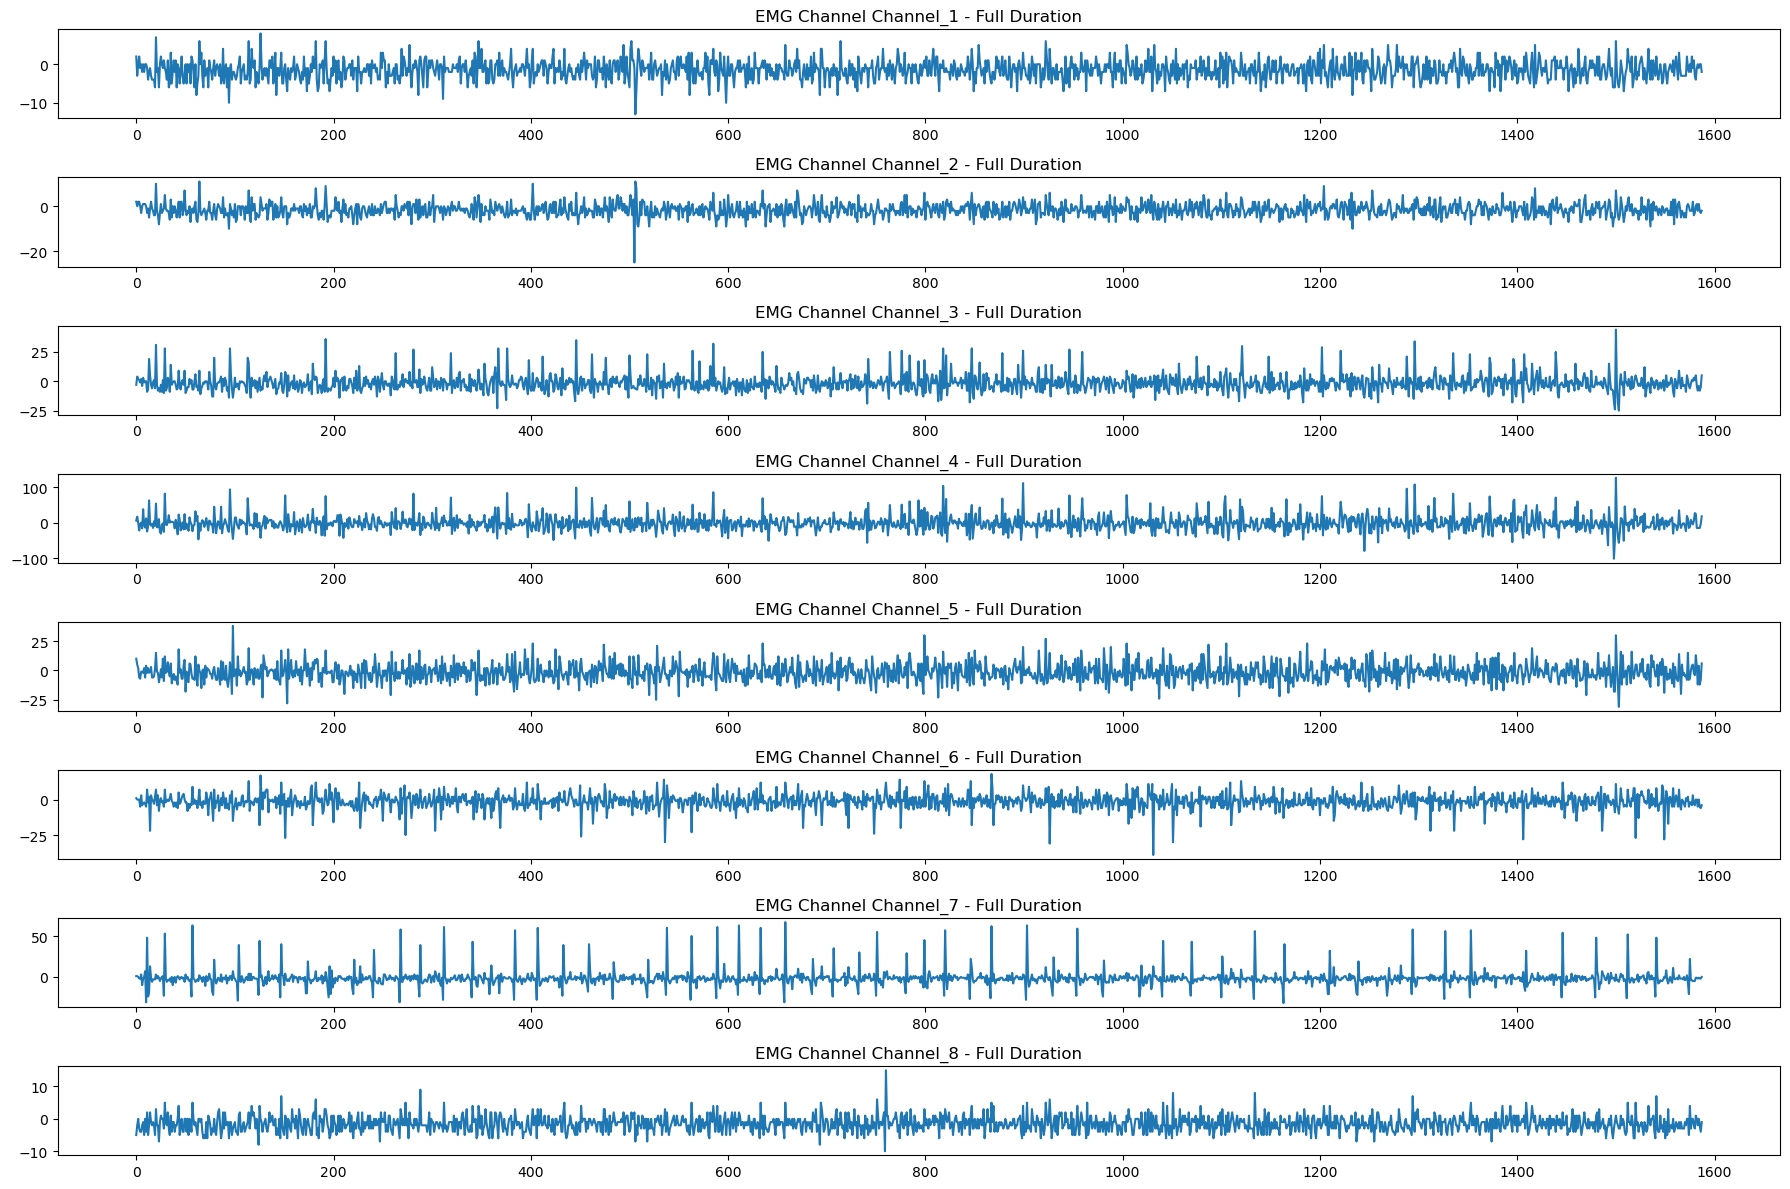

In [5]:
inspect_emg_data(emg_file)


EEG File Analysis: S8_R1_G7.csv
Raw Shape: (1349, 8) (Channels x Timepoints)
First 3 Channel Samples:
      Channel_1     Channel_2     Channel_3     Channel_4     Channel_5
0 -19022.921505 -36409.740020 -25105.926407 -44491.236745 -46551.553494
1 -18999.049842 -36443.468802 -24842.511099 -44195.456111 -46498.468101
2 -19047.888404 -36454.398805 -24955.856795 -44206.542576 -46544.557398


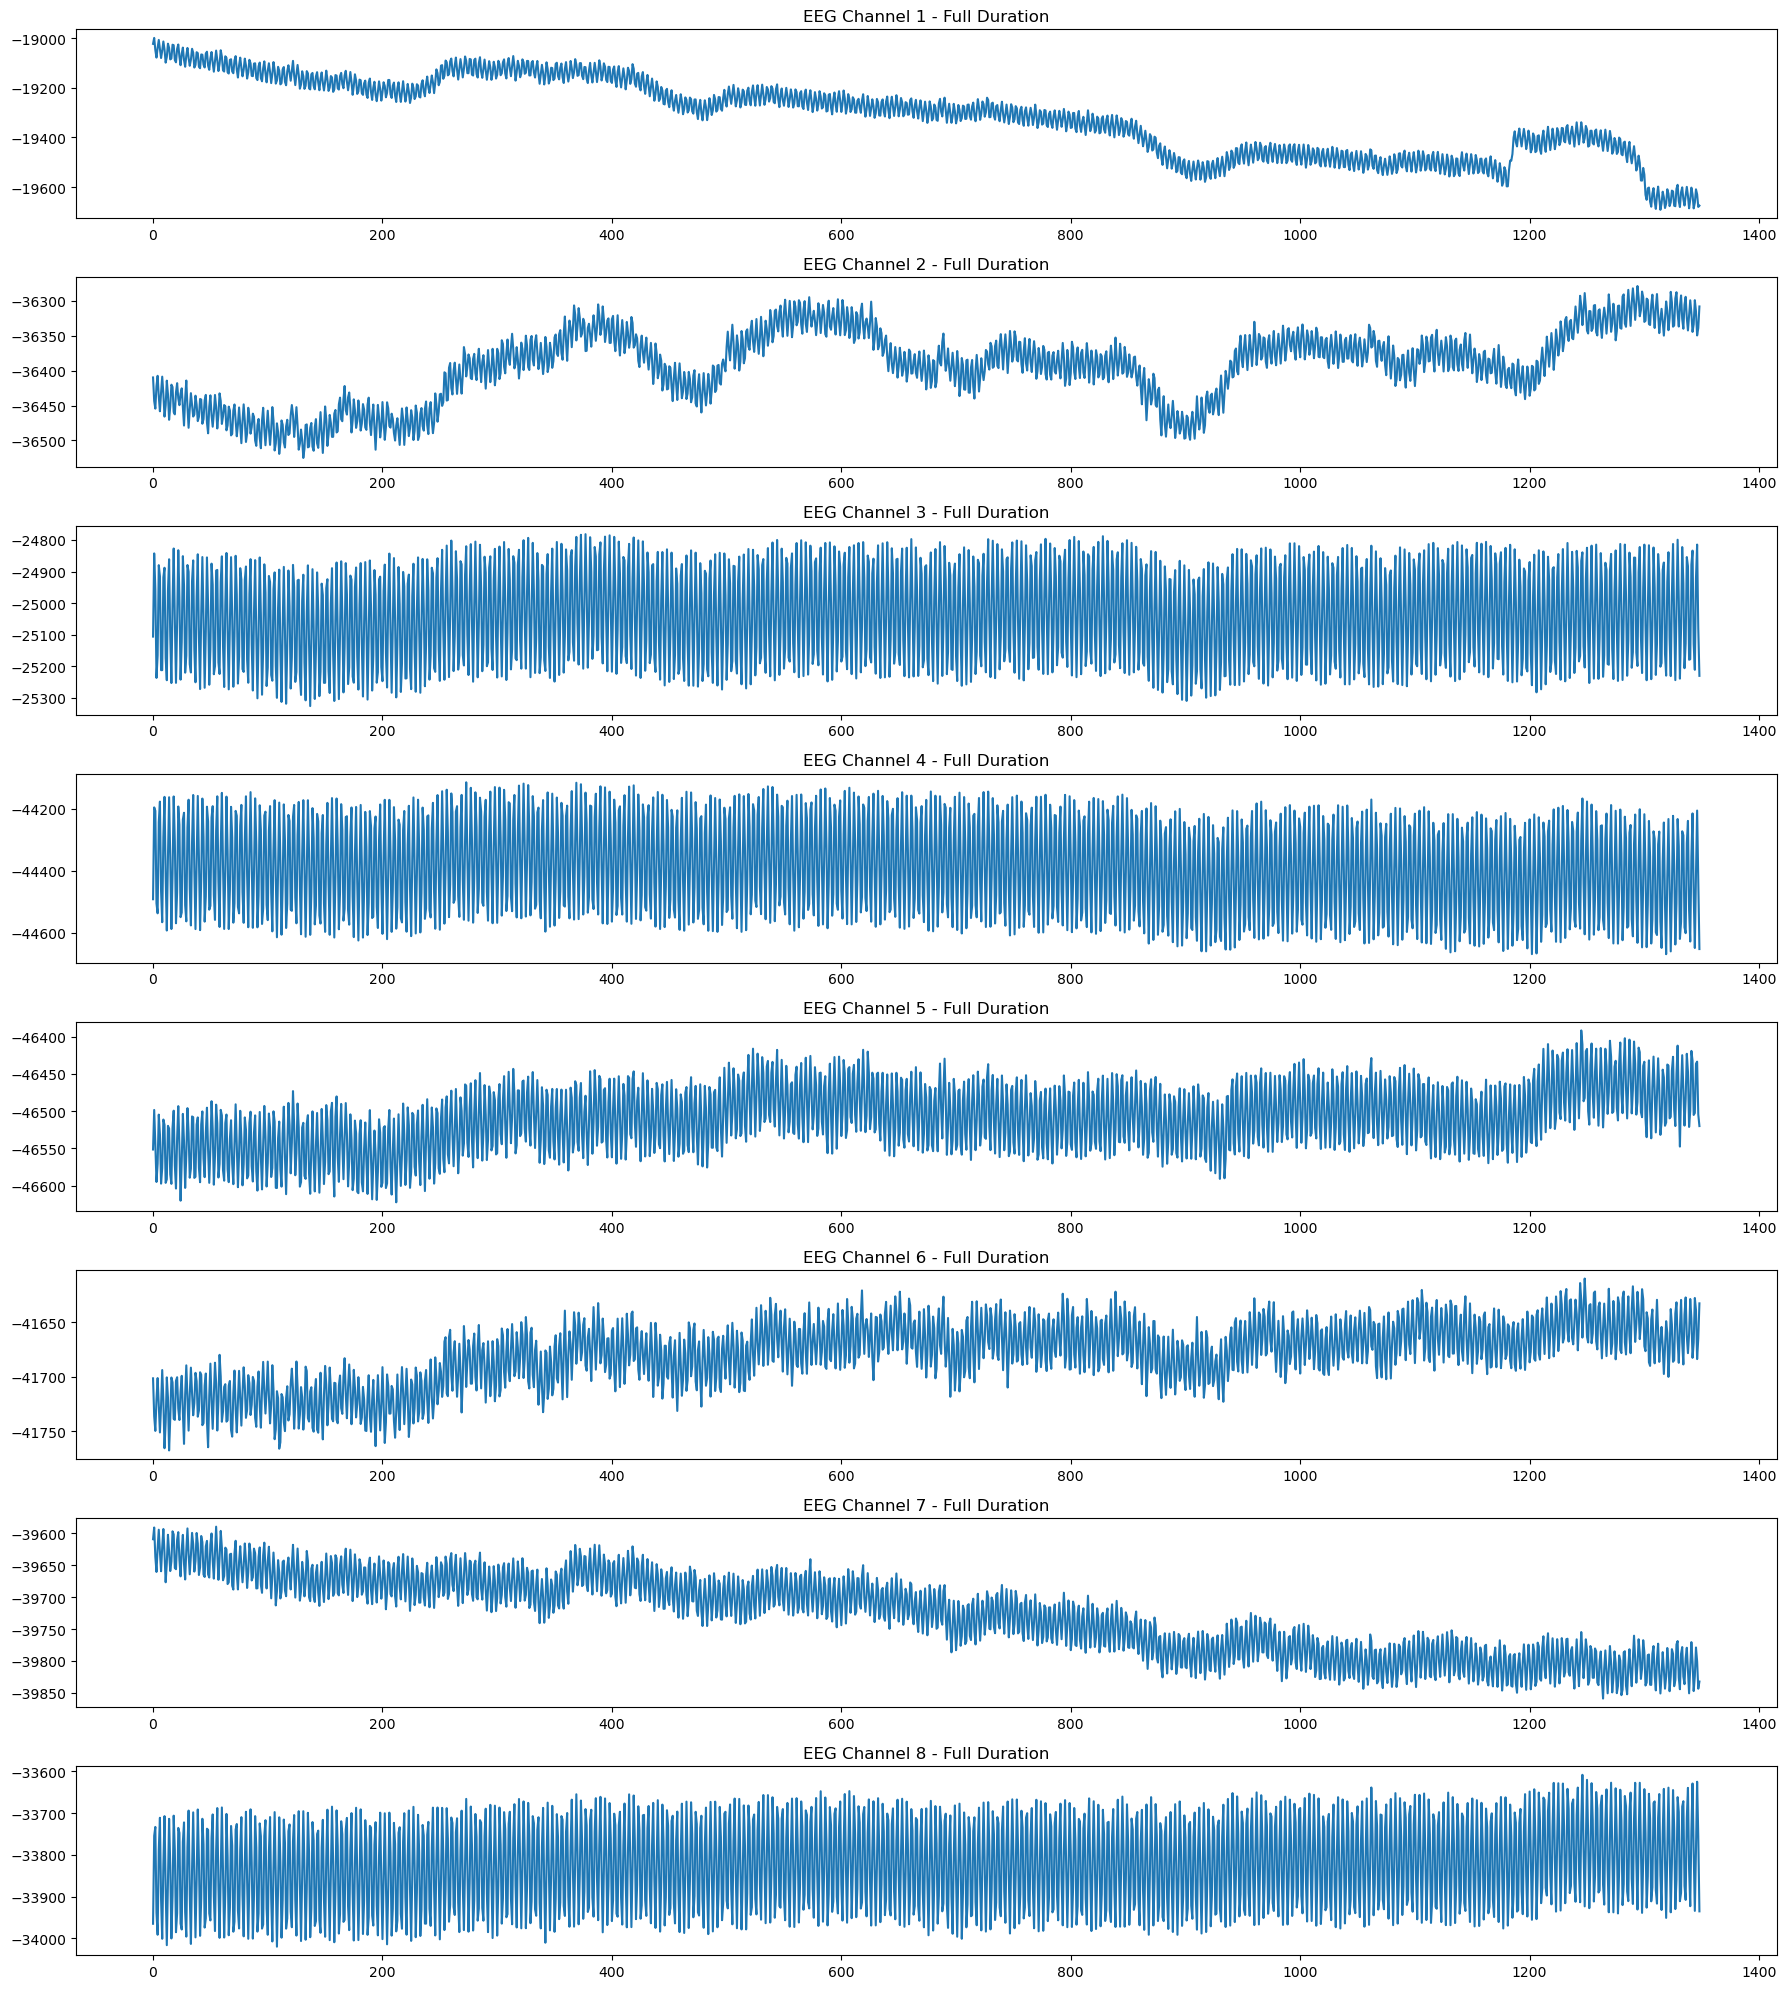


Time Axis Verification:
Start: 0.0ms, End: 1348.0ms
Sample Interval: 1.00ms


In [6]:
inspect_eeg_data(eeg_file)

## Data Processing 

process, validate, and aggregate raw EMG and EEG data

In [7]:
def collect_files(source_dir):
    """Collect all valid CSV files in the source directory."""
    file_list = []
    for subject_folder in tqdm(os.listdir(source_dir), desc=f"Scanning {source_dir} folders"):
        subject_path = os.path.join(source_dir, subject_folder)
        if os.path.isdir(subject_path):
            for fname in os.listdir(subject_path):
                if fname.endswith(".csv"):
                    sub_id, rep, gest = parse_filename(fname)
                    if sub_id is not None:
                        file_list.append((subject_path, fname, sub_id, rep, gest))
    return file_list

def process_data(file_list, process_function):
    """Process and aggregate data using the provided processing function."""
    all_dfs = []
    for subject_path, fname, sub_id, rep, gest in tqdm(file_list, desc="Processing files"):
        try:
            df = process_function(subject_path, fname, sub_id, rep, gest)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error processing {fname}: {e}")

    return all_dfs

def save_and_convert_data(all_dfs, output_path, data_type="EMG"):
    """Save and convert the aggregated data to tensors."""
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df.to_csv(output_path, index=False)
        
        features = torch.tensor(
            combined_df.drop(columns=["subject", "gesture", "repetition"]).values,
            dtype=torch.float32
        ).to(device)
        
        labels = torch.tensor(
            combined_df["gesture"].values,
            dtype=torch.long
        ).to(device)
        
        return features, labels

    raise ValueError(f"No valid {data_type} data processed")

# EMG-specific processing function
def process_emg_file(subject_path, fname, sub_id, rep, gest):
    """Process a single EMG file."""
    file_path = os.path.join(subject_path, fname)
    df = pd.read_csv(file_path)
    
    if df.shape[1] < 8:
        raise ValueError(f"Unexpected EMG format in {fname}")
        
    df["subject"] = sub_id
    df["repetition"] = rep
    df["gesture"] = gest
    return df

# EEG-specific processing function
def process_eeg_file(subject_path, fname, sub_id, rep, gest):
    """Process a single EEG file."""
    file_path = os.path.join(subject_path, fname)
    raw_data = pd.read_csv(file_path, header=None)
    
    channel_data = raw_data.iloc[1:, :]
    df = channel_data.T
    df.columns = [f"Channel_{i+1}" for i in range(df.shape[1])]
    
    df = df.assign(subject=sub_id, repetition=rep, gesture=gest)
    return df



In [8]:
print("Cleaning previous output files...")
for fpath in [EMG_OUTPUT, EEG_OUTPUT]:
    try:
        os.remove(fpath)
        print(f"Removed old file: {fpath}")
    except FileNotFoundError:
        print(f"File not found, skipping: {fpath}")

Cleaning previous output files...
File not found, skipping: data\processed\EMG-data.csv
File not found, skipping: data\processed\EEG-data.csv


In [9]:
# Collect EMG and EEG files separately
emg_file_list = collect_files(EMG_SOURCE)
eeg_file_list = collect_files(EEG_SOURCE)

# Process and save EMG data
print("Processing EMG data...")
emg_dfs = process_data(emg_file_list, process_emg_file)
emg_features, emg_labels = save_and_convert_data(emg_dfs, EMG_OUTPUT, data_type="EMG")

# Process and save EEG data
print("Processing EEG data...")
eeg_dfs = process_data(eeg_file_list, process_eeg_file)
eeg_features, eeg_labels = save_and_convert_data(eeg_dfs, EEG_OUTPUT, data_type="EEG")

Scanning data\raw\eeg_subjects_csv_data folders: 100%|██████████| 10/10 [00:00<00:00, 2500.78it/s]


Processing EMG data...


Processing files: 100%|██████████| 420/420 [00:02<00:00, 169.60it/s]


Processing EEG data...


Processing files: 100%|██████████| 420/420 [00:19<00:00, 21.47it/s]


In [10]:
# Check dimensions
print(f"\nEEG Features: {eeg_features.shape}, Labels: {eeg_labels.shape}")
print(f"EMG Features: {emg_features.shape}, Labels: {emg_labels.shape}")


EEG Features: torch.Size([564641, 8]), Labels: torch.Size([564641])
EMG Features: torch.Size([664666, 8]), Labels: torch.Size([664666])


## EMG and EMG Data Validation 

In [11]:

def validate_emg_processing(sample_file=None):
    """Validate EMG processing with proper timestamp handling"""
    if not sample_file:
        for root, dirs, files in os.walk(EMG_SOURCE):
            if files:
                sample_file = os.path.join(root, files[5])
                break

    print(sample_file)
    raw_emg = pd.read_csv(sample_file)
    print("Raw EMG File Structure:")
    print(f"Filename: {os.path.basename(sample_file)}")
    print(f"Shape: {raw_emg.shape} (timepoints x channels)")
    
    print("\nFirst 3 EMG channels and first 5 timepoints:")
    print(raw_emg.iloc[:5, :3])

    sub_id, rep, gest = parse_filename(os.path.basename(sample_file))
    processed_df = pd.read_csv(EMG_OUTPUT)
    processed_subset = processed_df[
        (processed_df['subject'] == sub_id) & 
        (processed_df['repetition'] == rep) &
        (processed_df['gesture'] == gest)
    ].reset_index(drop=True)

    print("\nProcessed EMG Structure:")
    print(f"Shape: {processed_subset.shape} (timepoints x channels+metadata)")
    print("First 3 timepoints and channels:")
    print(processed_subset.filter(like='Channel').iloc[:3, :3])

    raw_values = raw_emg.values.astype(float)
    processed_values = processed_subset.filter(like='Channel').values.astype(float)  # Fixed line

    if raw_values.shape != processed_values.shape:
        print(f"\nWarning: Shape mismatch detected! Raw: {raw_values.shape}, Processed: {processed_values.shape}")
        return
    
    mismatch = np.mean(np.abs(raw_values - processed_values), axis=0)
    print("\nData Integrity Check:")
    print("Mean Absolute Difference per Channel:")
    for i, diff in enumerate(mismatch):
        print(f"Channel {i+1}: {diff:.6f}")

    # Plot each channel separately in a new row
    num_channels = raw_values.shape[1]
    fig, ax = plt.subplots(num_channels * 2, 1, figsize=(14, 4 * num_channels * 2))

    if num_channels == 1:  # Handle single-channel case
        ax = [ax]

    for i in range(num_channels):
        # Plot Raw EMG Channel
        ax[i * 2].plot(raw_values[:, i], label=f'Raw Channel {i+1}')
        ax[i * 2].set_title(f"Raw EMG Channel {i+1}")
        ax[i * 2].set_xlabel('Timepoints')
        ax[i * 2].set_ylabel('Amplitude')
        ax[i * 2].legend()

        # Plot Processed EMG Channel
        ax[i * 2 + 1].plot(processed_values[:, i], label=f'Processed Channel {i+1}')
        ax[i * 2 + 1].set_title(f"Processed EMG Channel {i+1}")
        ax[i * 2 + 1].set_xlabel('Timepoints')
        ax[i * 2 + 1].set_ylabel('Amplitude')
        ax[i * 2 + 1].legend()

    plt.tight_layout()
    plt.show()



def validate_eeg_processing(sample_file=None):
    """Validate EEG processing with proper timestamp handling"""
    if not sample_file:
        for root, dirs, files in os.walk(EEG_SOURCE):
            if files:
                sample_file = os.path.join(root, files[5])
                break

    print(sample_file)
    raw_eeg = pd.read_csv(sample_file, header=None)
    print("Raw EEG File Structure:")
    print(f"Filename: {os.path.basename(sample_file)}")
    print(f"Shape: {raw_eeg.shape} (rows=timestamps+channels, columns=timestamps)")
    
    timestamps = raw_eeg.iloc[0, :]
    channels = raw_eeg.iloc[1:, :]
    
    print("\nTimestamp row (first 5 values):")
    print(timestamps[:5].values)
    print("\nFirst 3 EEG channels (rows 1-3) and first 5 timepoints:")
    print(channels.iloc[:3, :5])

    sub_id, rep, gest = parse_filename(os.path.basename(sample_file))
    processed_df = pd.read_csv(EEG_OUTPUT)
    processed_subset = processed_df[
        (processed_df['subject'] == sub_id) & 
        (processed_df['repetition'] == rep) &
        (processed_df['gesture'] == gest)
    ].reset_index(drop=True)

    print("\nProcessed EEG Structure:")
    print(f"Shape: {processed_subset.shape} (timepoints x channels+metadata)")
    print("First 3 timepoints and channels:")
    print(processed_subset.filter(like='Channel').iloc[:3, :3])

    raw_values = channels.values.astype(float)
    processed_values = processed_subset.filter(like='Channel').values.astype(float).T
    
    if raw_values.shape != processed_values.shape:
        print(f"\nWarning: Shape mismatch detected! Raw: {raw_values.shape}, Processed: {processed_values.shape}")
        return
    
    mismatch = np.mean(np.abs(raw_values - processed_values), axis=1)
    print("\nData Integrity Check:")
    print("Mean Absolute Difference per Channel:")
    for i, diff in enumerate(mismatch):
        print(f"Channel {i+1}: {diff:.6f}")

    # Plot each channel in a new row for raw and processed separately
    num_channels = raw_values.shape[0]
    fig, ax = plt.subplots(num_channels * 2, 1, figsize=(14, 4 * num_channels * 2))  # 2 plots per channel (raw + processed)

    if num_channels == 1:  # To handle the case where there's only one channel
        ax = [ax]

    for i in range(num_channels):
        # Plot Raw EEG Channel
        ax[i * 2].plot(raw_values[i, :], label=f'Raw Channel {i+1}')
        ax[i * 2].set_title(f"Raw EEG Channel {i+1}")
        ax[i * 2].set_xlabel('Timepoints')
        ax[i * 2].set_ylabel('Amplitude')
        ax[i * 2].legend()

        # Plot Processed EEG Channel
        ax[i * 2 + 1].plot(processed_values[i, :], label=f'Processed Channel {i+1}')
        ax[i * 2 + 1].set_title(f"Processed EEG Channel {i+1}")
        ax[i * 2 + 1].set_xlabel('Timepoints')
        ax[i * 2 + 1].set_ylabel('Amplitude')
        ax[i * 2 + 1].legend()

    plt.tight_layout()
    plt.show()


data\raw\emg_subjects_csv_data\subject_8\S8_R1_G7.csv
Raw EMG File Structure:
Filename: S8_R1_G7.csv
Shape: (1588, 8) (timepoints x channels)

First 3 EMG channels and first 5 timepoints:
   Channel_1  Channel_2  Channel_3
0          2          2         -3
1         -3          0          4
2          0          2          2
3          2          2          1
4         -1          0         -1

Processed EMG Structure:
Shape: (1588, 11) (timepoints x channels+metadata)
First 3 timepoints and channels:
   Channel_1  Channel_2  Channel_3
0          2          2         -3
1         -3          0          4
2          0          2          2

Data Integrity Check:
Mean Absolute Difference per Channel:
Channel 1: 0.000000
Channel 2: 0.000000
Channel 3: 0.000000
Channel 4: 0.000000
Channel 5: 0.000000
Channel 6: 0.000000
Channel 7: 0.000000
Channel 8: 0.000000


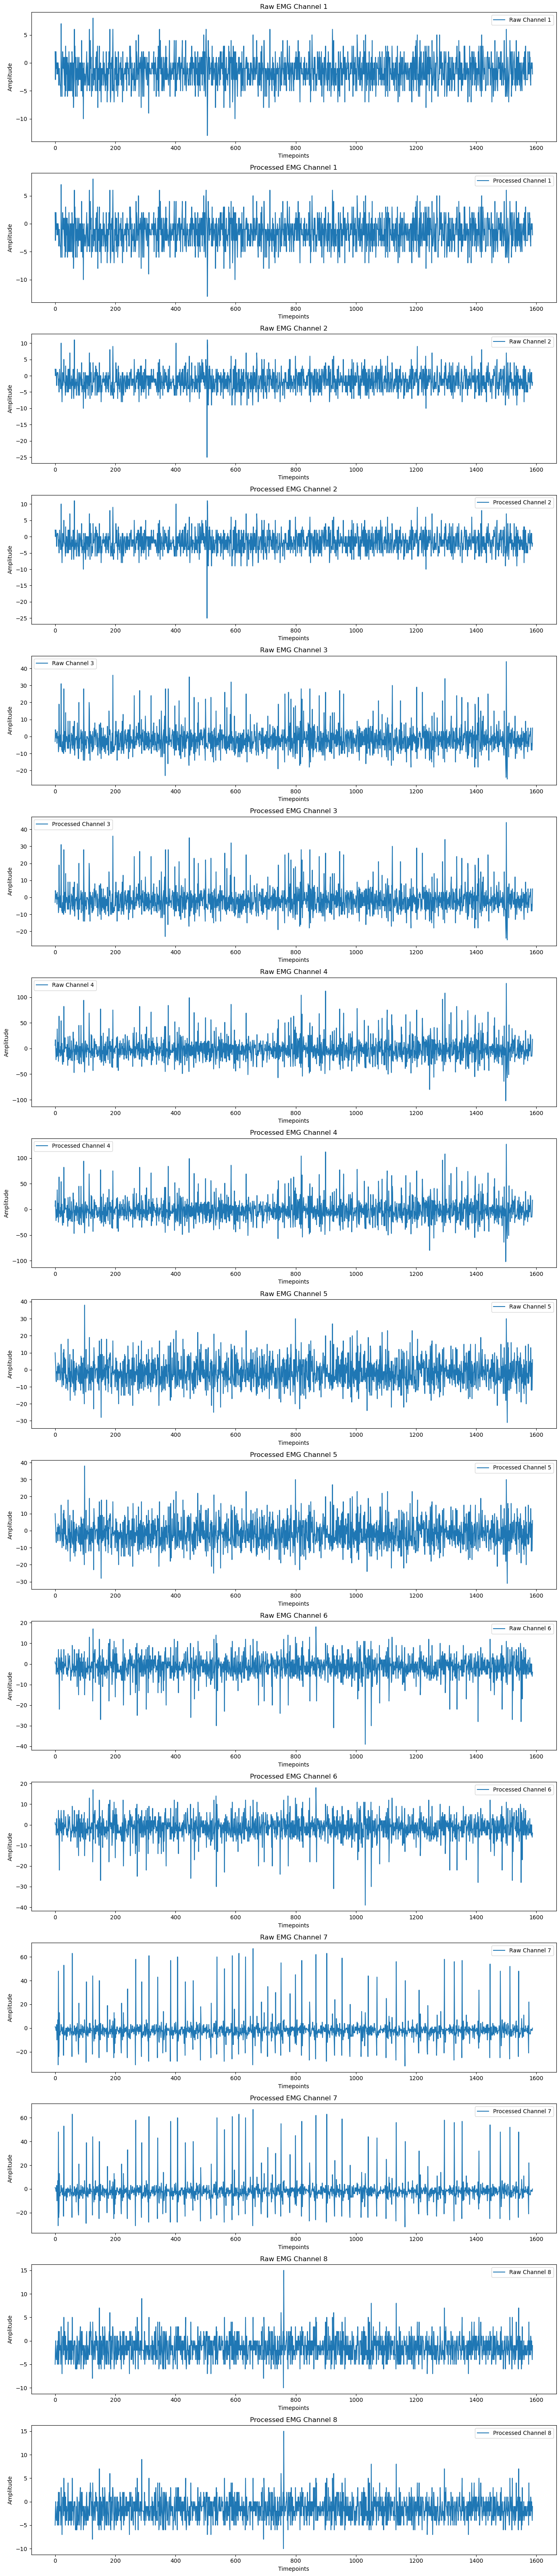

In [12]:

validate_emg_processing(emg_file)

data\raw\eeg_subjects_csv_data\subject_8\S8_R1_G7.csv
Raw EEG File Structure:
Filename: S8_R1_G7.csv
Shape: (9, 1349) (rows=timestamps+channels, columns=timestamps)

Timestamp row (first 5 values):
[0. 1. 2. 3. 4.]

First 3 EEG channels (rows 1-3) and first 5 timepoints:
              0             1             2             3             4
1 -19022.921505 -18999.049842 -19047.888404 -19078.242073 -19038.970058
2 -36409.740020 -36443.468802 -36454.398805 -36422.189942 -36407.370735
3 -25105.926407 -24842.511099 -24955.856795 -25236.840574 -25165.158530

Processed EEG Structure:
Shape: (1349, 11) (timepoints x channels+metadata)
First 3 timepoints and channels:
      Channel_1     Channel_2     Channel_3
0 -19022.921505 -36409.740020 -25105.926407
1 -18999.049842 -36443.468802 -24842.511099
2 -19047.888404 -36454.398805 -24955.856795

Data Integrity Check:
Mean Absolute Difference per Channel:
Channel 1: 0.000000
Channel 2: 0.000000
Channel 3: 0.000000
Channel 4: 0.000000
Channel 5: 0.

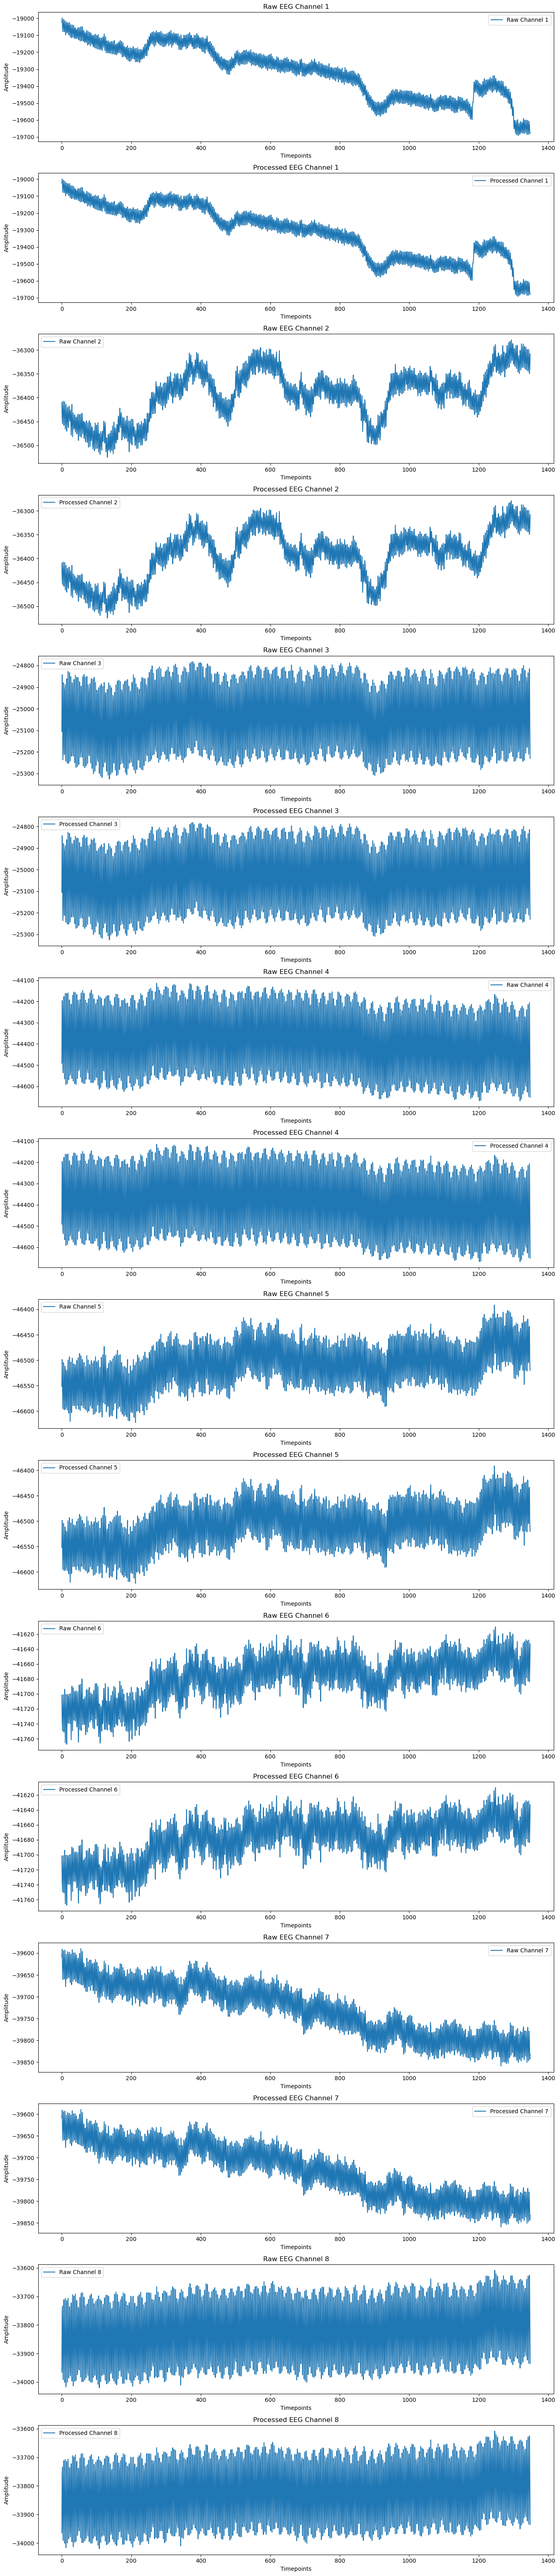

In [13]:

validate_eeg_processing(eeg_file)